In [1]:
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from data import JsonDataset, get_samplers
from data import domain, split_data
from torch.utils.data.sampler import SubsetRandomSampler
from copy import deepcopy
import pandas as pd
import numpy as np
#from plot import plot_heat_map

if False:
    print("using gpu")
    cuda = torch.device('cuda')
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor
    def cudaify(model):
        return model.cuda()
else: 
    print("using cpu")
    cuda = torch.device('cpu')
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor
    def cudaify(model):
        return model
    
UNITS_PER_SIZE = 50

using cpu


In [2]:
class Vocab:
    """
    A simple vocabulary class that takes an alphabet of symbols,
    and assigns each symbol a unique integer id., e.g.
    
    > v = Vocab(['a','b','c','d'])
    > v('c')
    2
    > v('a')
    0
    > len(v)
    4
    
    """
    def __init__(self, alphabet):
        self.alphabet = alphabet
        self.index_map = {letter: index for (index, letter) in 
                          list(enumerate(alphabet))}
        
    def __len__(self):
        return len(self.alphabet)
        
    def __call__(self, letter):
        return self.index_map[letter]

In [3]:
class Tensorize:
    """
    An instance of Tensorize is a function that maps a piece of data
    (i.e. a dictionary) to an input and output tensor for consumption by
    a neural network.
    """
    
    def __init__(self, symbol_vocab, max_word_length, category_vocab):
        self.symbol_vocab = symbol_vocab
        self.category_vocab = category_vocab
        self.max_word_length = max_word_length
    
    def __call__(self, data):
        words = Tensorize.words_to_tensor(data['seq'], 
                                              self.symbol_vocab, 
                                              self.max_word_length).float()
        
        #print(len(data['tfs']))
        #print(torch.stack(data['tfs']).shape)
        tfs = torch.stack(data['tfs'],dim=1).float()
        #print(type(data['exp']))
        category = LongTensor([self.category_vocab(c) 
                             for c in data['exp']])
        
        return cudaify(words), cudaify(tfs), cudaify(category)
        
    @staticmethod
    def words_to_tensor(words, vocab, max_word_length):
        """
        Turns an K-length list of words into a <K, len(vocab), max_word_length>
        tensor.
    
        e.g.
            t = words_to_tensor(['BAD', 'GAB'], Vocab('ABCDEFG'), 3)
            # t[0] is a matrix representations of 'BAD', where the jth
            # column is a one-hot vector for the jth letter
            print(t[0])
    
        """
        tensor = torch.zeros(len(words), len(vocab), max_word_length)
        for i, word in enumerate(words):
            for li, letter in enumerate(word):
                tensor[i][vocab(letter)][li] = 1
        return tensor

In [4]:
class ProCNN(torch.nn.Module):
    """
    A CNN neural network takes sequence data, a fully connnected network takes TF data
    then, the outputs are concatenated and trains a fully connected neural network
    on the final layers.
    
    """    
    def __init__(self, n_input_symbols, hidden_size,
                 input_symbol_vocab, output_classes):
        super(ProCNN, self).__init__()
        
        self.input_symbol_vocab = input_symbol_vocab
        
        self.hidden_size=hidden_size
        
        self.output_classes = output_classes
        
        self.conv1 = torch.nn.Conv1d(n_input_symbols,128, kernel_size=19, stride=1, padding=19//2)
        self.pool1 = torch.nn.MaxPool1d(kernel_size=20, stride=20)
        self.conv2 = torch.nn.Conv1d(128,32, kernel_size=9, stride=1, padding=4)
        self.pool2 = torch.nn.MaxPool1d(kernel_size=10, stride=10)
        
        self.fc_t = torch.nn.Linear(325,hidden_size) #assuming 325 TFs
        
        self.fc1 = torch.nn.Linear(32*5+hidden_size, 512)
        self.bn1 = torch.nn.BatchNorm1d(num_features=512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, 64)
        self.fc_out = torch.nn.Linear(64,output_classes)
    
    def get_input_vocab(self):
        return self.input_symbol_vocab
    
    def get_hidden(self, x):
        pass
    
    def forward(self, x_s, x_t):
        b=list(x_s.size())[0] #batch size
        x_s = self.conv1(x_s)
        x_s = self.pool1(x_s)
        x_s = F.relu(x_s)
        x_s = self.conv2(x_s)
        x_s = self.pool2(x_s)
        x_s = F.relu(x_s)
        
        x_t = F.relu(self.fc_t(x_t))
        
        x = torch.cat((x_s.reshape((b,32*5,1)).view(-1, 32*5),x_t),1)
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc_out(x)
        #print(self.convs[0].weight.data)
        #yay!
        return x

In [5]:
class CnnClassifier:
    """
    Wraps a trained neural network to use for classification.
    
    """    
    def __init__(self, cnn, tensorize):
        self.net = cnn
        self.tensorize = tensorize
     
    def run(self, data_loader):
        for data in data_loader:
            inputs, _ = self.tensorize(data)
            yield self.net(inputs)  
            
    def evaluate(self, data_loader):
        """
        To fix
        """
        correct = 0
        total = 0
        confusion_mat=[[0 for j in range(self.net.output_classes)]for i in range(self.net.output_classes)]
        for data in data_loader:
            input_s, input_t, labels = self.tensorize(data)
            outputs = self.net(input_s,input_t)
            correct_inc, total_inc = CnnClassifier.accuracy(outputs, labels)
            confusion_mat_inc = CnnClassifier.confusion(outputs, labels)
            correct += correct_inc
            total += total_inc
            for i in range(len(confusion_mat)):
                for j in range(len(confusion_mat)):
                    confusion_mat[i][j]+=confusion_mat_inc[i][j]
        return correct / total, confusion_mat
    
    @staticmethod
    def accuracy(outputs, labels):
        correct = 0
        total = 0
        for output, label in zip(outputs, labels):
            total += 1
            if label.item() == output.argmax().item():
                correct += 1
        return correct, total
    
    @staticmethod
    def confusion(outputs,labels):
        mat=[[0 for j in range(len(outputs[0]))]for i in range(len(outputs[0]))]
        for output, label in zip(outputs,labels):
            i = output.argmax().item()
            j=label.item()
            mat[i][j]+=1
        return mat

In [6]:
dataset = JsonDataset('test_file_oav_filt05_filtcv3_Zlog_tri.json')
_, sampler, _ = get_samplers(range(len(dataset)), .05, .05)
loader =  DataLoader(dataset, batch_size=125, sampler=sampler, num_workers=0)

In [7]:
def extract_nucleotide_alphabet(dataset):
    symbols = set()
    for sequence in dataset.select('seq'):
        letters = set(sequence)
        symbols = symbols | letters
    return sorted(list(symbols))
char_vocab = Vocab(extract_nucleotide_alphabet(dataset))
categories = sorted(list(set(dataset.select('exp'))))
category_vocab = Vocab(categories)
tens = Tensorize(char_vocab, 1024, category_vocab)
char_vocab.index_map

{'A': 0, 'C': 1, 'G': 2, 'N': 3, 'T': 4}

In [8]:
model = torch.load('current_best_f_cv5_lt_v2.nnt')
model.eval()
model

ProCNN(
  (conv1): Conv1d(5, 128, kernel_size=(19,), stride=(1,), padding=(9,))
  (pool1): MaxPool1d(kernel_size=20, stride=20, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 32, kernel_size=(9,), stride=(1,), padding=(4,))
  (pool2): MaxPool1d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  (fc_t): Linear(in_features=325, out_features=256, bias=True)
  (fc1): Linear(in_features=416, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc_out): Linear(in_features=64, out_features=3, bias=True)
)

In [9]:
threshold = 0.7 # threshold for significant activations
window = 20 #window size of alignment 

# Get feature maps of first convolutional layer after activation
cnn_conv = torch.nn.Sequential(*list(model.children())[:1]+[torch.nn.ReLU()])
cnn_conv

Sequential(
  (0): Conv1d(5, 128, kernel_size=(19,), stride=(1,), padding=(9,))
  (1): ReLU()
)

In [10]:
cnn_conv.eval()
fmap = []
x_test = []
batches = len(loader)
for i, data in enumerate(loader, 0):
    input_s, input_t, labels = tens(data)
    fmap.append(cnn_conv(input_s))
    x_test.append(input_s)
    if i%10==0:
        print(i/batches)

0.0
0.04950495049504951
0.09900990099009901
0.1485148514851485
0.19801980198019803
0.24752475247524752
0.297029702970297
0.3465346534653465
0.39603960396039606
0.44554455445544555
0.49504950495049505
0.5445544554455446
0.594059405940594
0.6435643564356436
0.693069306930693
0.7425742574257426
0.7920792079207921
0.8415841584158416
0.8910891089108911
0.9405940594059405
0.9900990099009901


In [11]:
fmap = torch.cat(fmap, dim=0)
fmap = fmap.detach().cpu().numpy()

In [12]:
x_test = torch.cat(x_test, dim=0)
x_test = x_test.detach().cpu().numpy()

In [13]:
# Set the left and right window sizes
window_left = int(window/2)
window_right = window - window_left

num_filters = fmap.shape[1]
N_test = x_test.shape[0]
L = x_test.shape[2]

W = []
for filter_index in range(num_filters):
    # Find regions above threshold
    coords = np.where(fmap[:,filter_index,:] > np.max(fmap[:,filter_index,:])*threshold)
    x, y = coords

    # Sort score
    index = np.argsort(fmap[x,filter_index,y])[::-1]
    data_index = x[index].astype(int)
    pos_index = y[index].astype(int)

    # Make a sequence alignment centered about each activation (above threshold)
    seq_align = []
    for i in range(len(pos_index)):

        # Determine position of window about each filter activation
        start_window = pos_index[i] - window_left
        end_window = pos_index[i] + window_right
        # Check to make sure positions are valid
        if (start_window > 0) & (end_window < L):
            seq = x_test[data_index[i],:,start_window:end_window] 
            seq_align.append(seq)
    # Calculate position probability matrix
    if len(seq_align) > 0:
        W.append(np.mean(seq_align, axis=0))
    else:
        W.append(np.ones((window, A))/5)
W = np.array(W)

5 128 20


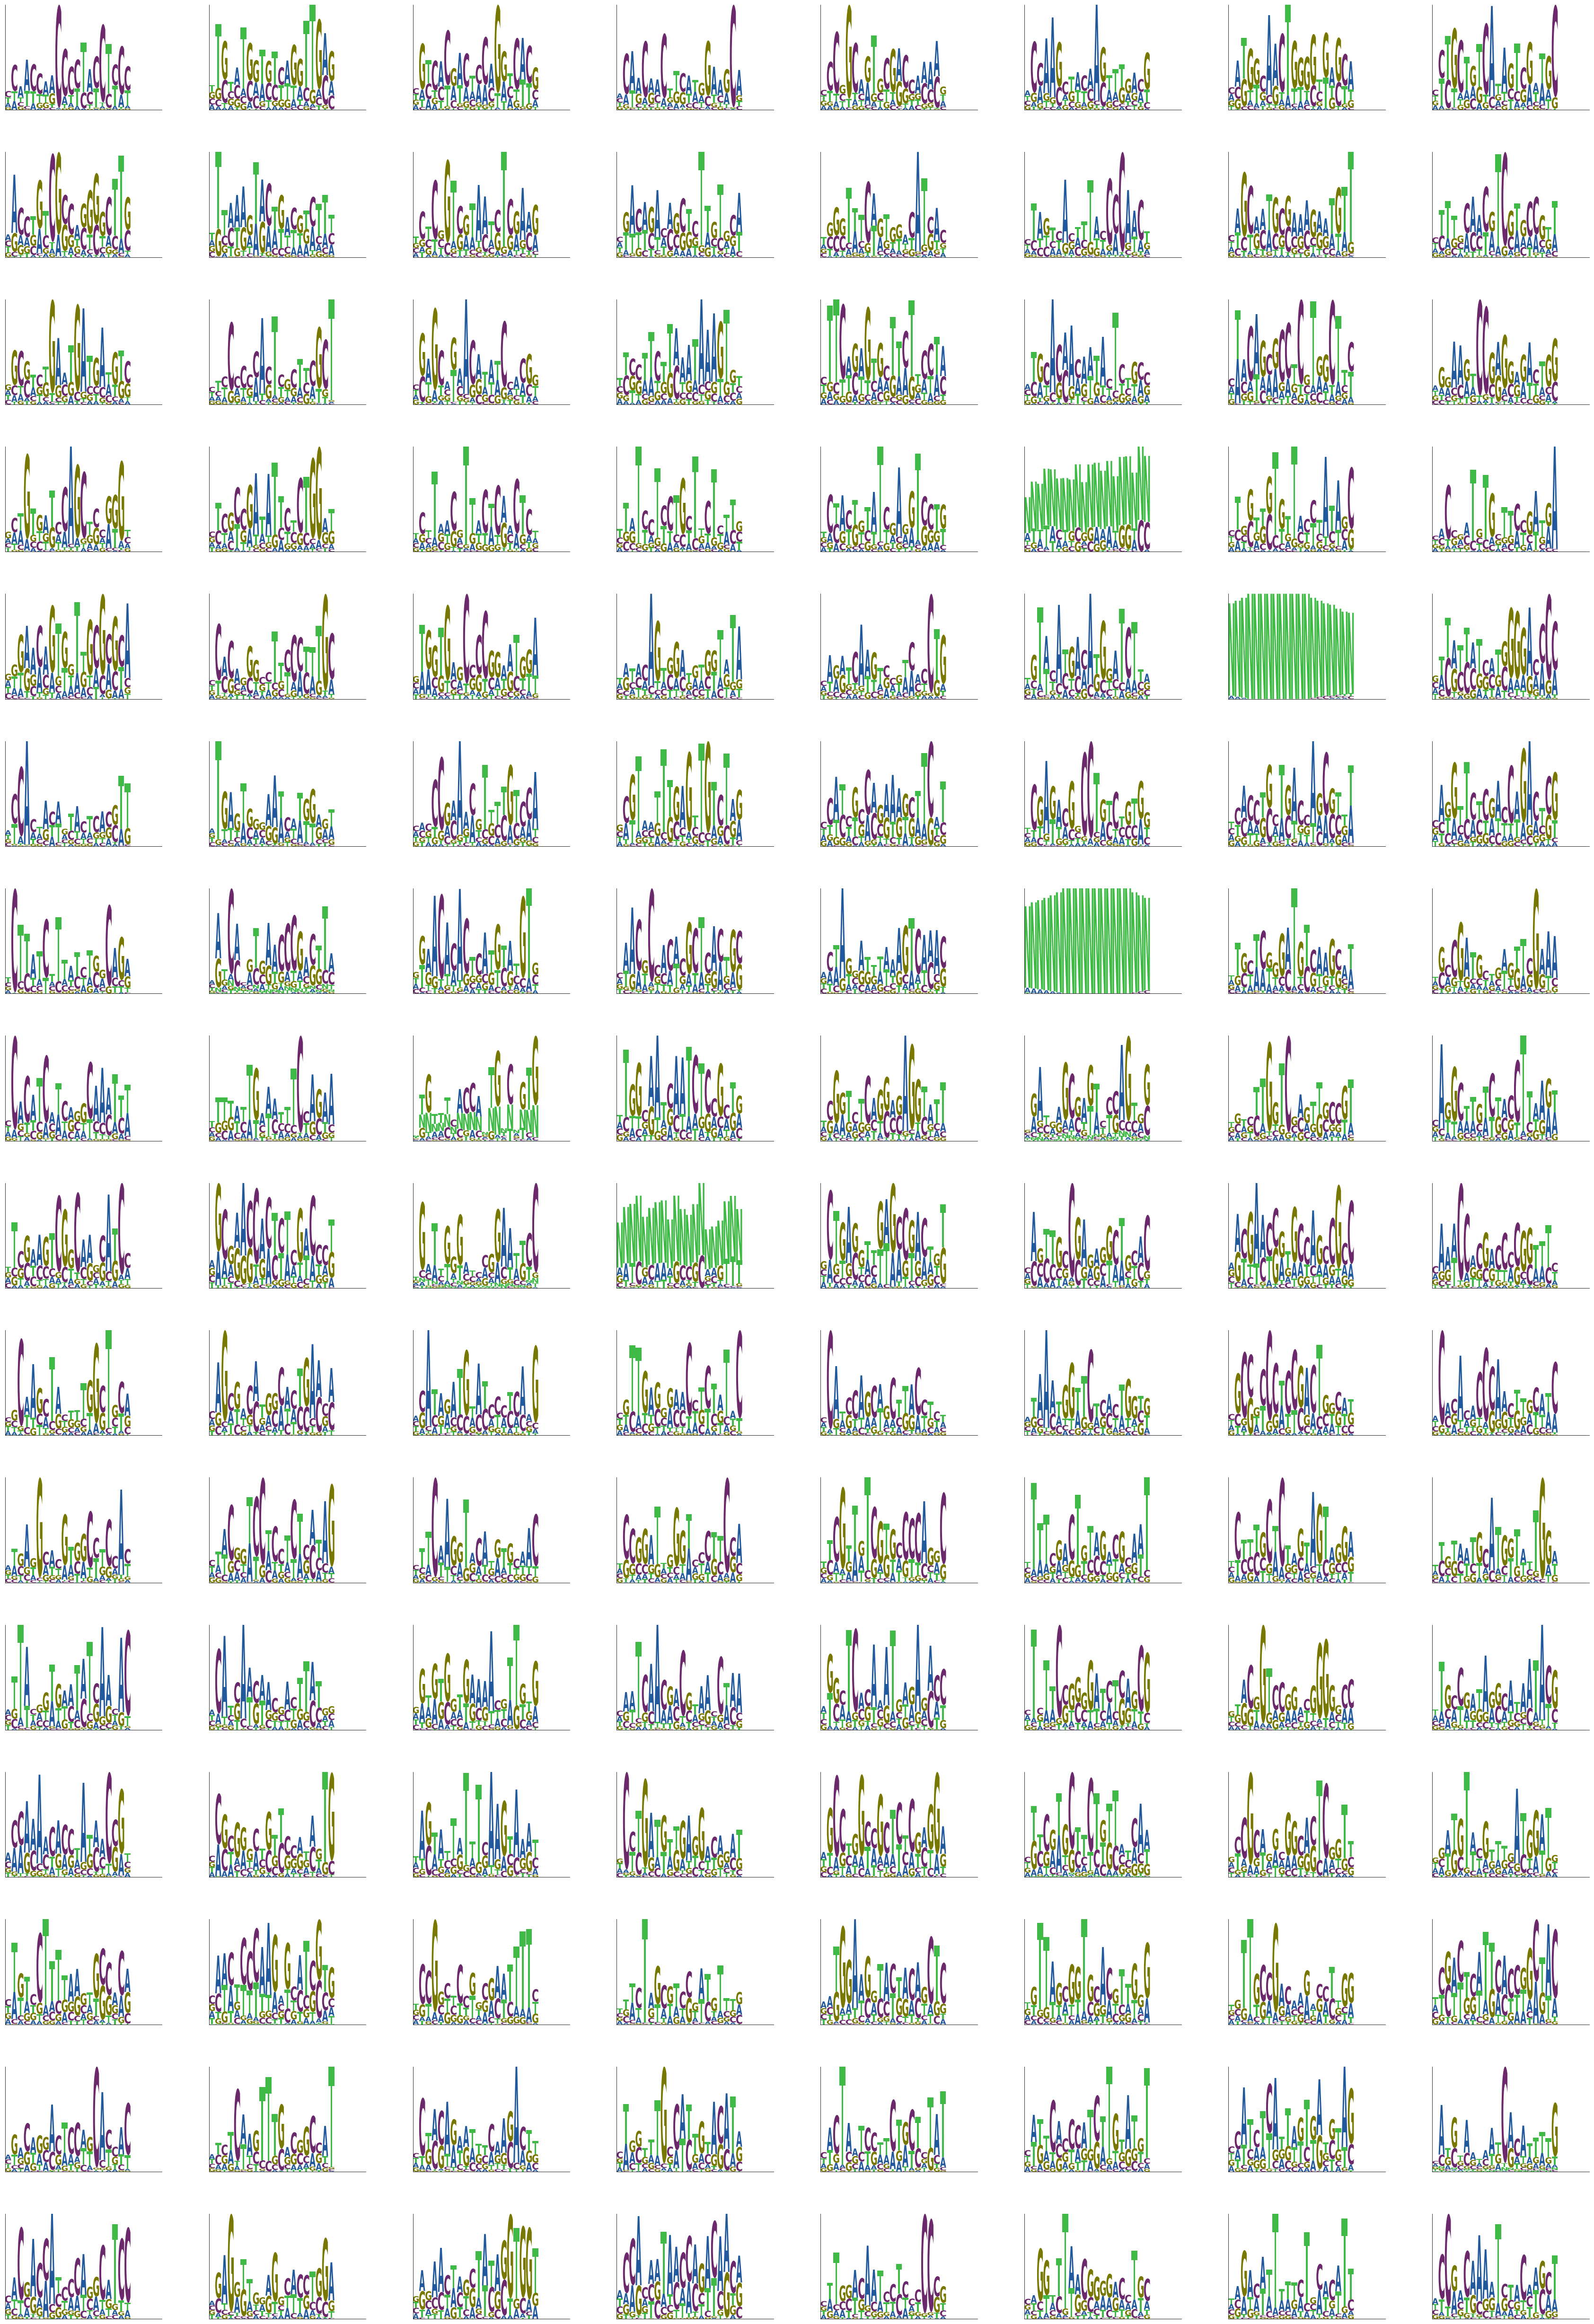

In [15]:
import logomaker
import matplotlib.pyplot as plt
num_filter, A, filter_len = W.shape
print(A,num_filter,filter_len)

fig = plt.figure(figsize=(60,90))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

num_cols = 8
num_widths = 16
motif_ls = []
for n, w in enumerate(W):
    ax = fig.add_subplot(num_widths, num_cols, n+1)
    # Calculate sequence logo heights -- information
    I = np.log2(5) + np.sum(w * np.log2(w+1e-7), axis=0, keepdims=True)
    logo = I*w

    # Create DataFrame for logomaker
    counts_df = pd.DataFrame(data=0.0, columns=list('ACGNT'), index=list(range(25)))
    for a in range(A):
        for l in range(filter_len):
            counts_df.iloc[l,a] = logo[a,l]

    motif_ls.append(counts_df)
    # Plot filter representation
    logomaker.Logo(counts_df, ax=ax, color_scheme='NajafabadiEtAl2017')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    plt.xticks([])
    plt.yticks([])
    
fig.savefig('filter_vis2.pdf', format='pdf', bbox_inches='tight')
fig.show()